In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
from census import Census # This is new...
from scipy.stats.mstats import gmean

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

https://www.imf.org/external/np/sta/tegppi/ch20.pdf

This .pdf plug in the different chapters gives a good idea about stuff. 20 talks about elemetry indicies, so say do that at a low level, then when you aggregate do something like a tornqvist of fisher

I'm going to follow Broda and Weinstein (2006) https://web.stanford.edu/~klenow/Broda_and_Weinstein.pdf in setting things up.

The first question is level of aggregation and what a variety is. I'm going to do this at the HS4 level. What this means is then each HS10 product X country within the HS4 code is a variety. 

In [34]:
def make_expenditure_shares(df):
    
    df["S_gct"] = df["CON_VAL_MO"] / df["CON_VAL_MO"].sum()
    
    df["log_S_gct"] = np.nan
    
    df["log_S_gct"][df["CON_VAL_MO"]>0] = np.log( df["S_gct"][df["CON_VAL_MO"]>0] )
     
    return df

In [108]:
def price_growth(df):
    
    foo = pd.DataFrame()
    
    log_P_t = (np.log(df["price"])).sum()

    foo["log_P_t"] = [log_P_t]
        
    return foo

In [26]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"
# This is my key. I'm nice and I have it posted. If you will be doing more with this
# please get your own key!

In [27]:
end_use = "hs?get=CON_VAL_MO,CTY_NAME,I_COMMODITY_SDESC,CON_QY1_MO,UNIT_QY1"

url = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 
url = url + my_key + "&time==from+2013-01" + "&COMM_LVL=HS10" + "&I_COMMODITY=4407*" + "&CTY_CODE=5700"+ "&CTY_CODE=1200"

# This will grab all products that fall under the "non-alloyed unwrought aluminum"
# and will have the quantity values that all appear to be in Killograms

r = requests.get(url) 
    
print(r)
    
df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
    # Note that the first entry is the labels

df.columns = r.json()[0]

df.time = pd.to_datetime(df.time, format="%Y-%m")

df["CON_VAL_MO"] = df["CON_VAL_MO"].astype(float)

df["CON_QY1_MO"] = df["CON_QY1_MO"].astype(float)

df["price"] = df.CON_VAL_MO / df.CON_QY1_MO

<Response [200]>


In [43]:
df

,CON_VAL_MO,CTY_NAME,I_COMMODITY_SDESC,CON_QY1_MO,UNIT_QY1,time,COMM_LVL,I_COMMODITY,CTY_CODE,price
0,282601.0,CHINA,"FINGER-JOINTED, CONI",458.0,M3,2013-01-01,HS10,4407100101,5700,617.032751
1,7795.0,CHINA,LODGEPOLE PINE LUMB,6.0,M3,2013-01-01,HS10,4407100145,5700,1299.166667
2,10303.0,CHINA,"FIR,LUMBER,NOT TRE",33.0,M3,2013-01-01,HS10,4407100159,5700,312.212121
3,369050.0,CHINA,"WEST RED CEDR, LUM",332.0,M3,2013-01-01,HS10,4407100169,5700,1111.596386
4,3703.0,CHINA,"CEDAR NESOI,LUMBER,NOT TR",1.0,M3,2013-01-01,HS10,4407100177,5700,3703.000000
...,...,...,...,...,...,...,...,...,...,...
2137,3000.0,CHINA,"ASH WOOD, SAWN OR CHIPPED LENG",1.0,M3,2021-03-01,HS10,4407950000,5700,3000.000000
2138,172643.0,CHINA,"EUROPEAN BIRCH WOOD, SAWN LENGTHWISE, GT 6MM T...",653.0,M3,2021-03-01,HS10,4407960013,5700,264.384380
2139,0.0,CHINA,POPLAR/ASPEN/COTTONWOOD SAWN LNGTHW GT 6MM THK...,0.0,M3,2021-03-01,HS10,4407970079,5700,NaN
2140,0.0,CHINA,"WESTERN RED ALDER SAWN LENGTHW, GT 6MM THICK",0.0,M3,2021-03-01,HS10,4407990263,5700,NaN


In [109]:
grp = df.groupby(["time"])

test = grp.apply(price_growth)

In [115]:
test.reset_index(inplace = True)

test.set_index(["time"], inplace = True)

test.drop(["index", "level_1"], axis = 1, inplace = True)

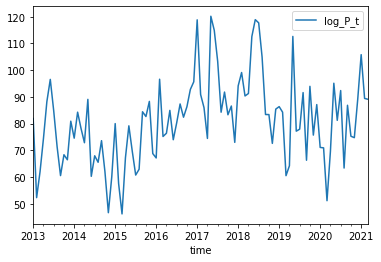

In [117]:
test.plot()

In [203]:
df["log_price"] = np.log(df.price)

grp = df.groupby(["time"])

foo = grp.aggregate({"log_price": "mean", "I_COMMODITY": "count"})

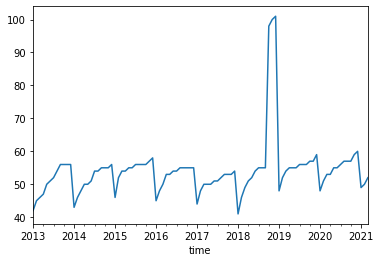

In [204]:
foo.I_COMMODITY.plot()

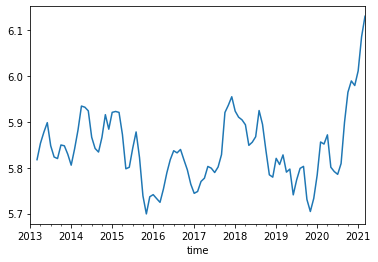

In [206]:
foo.log_price.rolling(3).mean().plot()

In [126]:
def make_expenditure_shares(df, year):
    
    foo = df.set_index(["time"]).loc[year].copy()
    
    grp = foo.groupby(["I_COMMODITY"])
    
    foobar = grp.aggregate({"CON_VAL_MO": "sum", "CON_QY1_MO": "sum", "I_COMMODITY_LDESC": "first"})
    
    foobar["EXP_WEIGHT"] = foobar["CON_VAL_MO"] / foobar["CON_VAL_MO"].sum()
    
    foobar["BASE_PRICE"] = foobar["CON_VAL_MO"] / foobar["CON_QY1_MO"]
     
    return foobar

In [141]:
foo = make_expenditure_shares(df, "2019")

In [142]:
foo.sort_values(by = "EXP_WEIGHT", ascending = False)

,CON_VAL_MO,CON_QY1_MO,I_COMMODITY_LDESC,EXP_WEIGHT,BASE_PRICE
I_COMMODITY,,,,,
4407190500,3.308413e+09,26396488.0,MIXTURES OF SPRUCE/PINE/FIR (S-P-F) SAWN/CHIPP...,0.571869,125.335332
4407120020,2.802732e+08,1082276.0,"SPRUCE, SAWN OR CHIPPED LENGTHWISE, SLICED OR ...",0.048446,258.966487
4407191069,2.497664e+08,575950.0,"WESTERN RED CEDAR (THUJA PLICATA), SAWN OR CHI...",0.043173,433.659807
4407191068,2.296867e+08,490814.0,"WESTERN RED CEDAR (THUJA PLICATA), SAWN OR CHI...",0.039702,467.970865
4407110001,1.872748e+08,356809.0,"PINE (PINUS), SAWN OR CHIPPED LENGTHWISE, SLIC...",0.032371,524.860009
...,...,...,...,...,...
4407990242,4.310840e+05,809.0,"HICKORY (CARYA) AND PECAN (CARYA ILLINOENSIS, ...",0.000075,532.860321
4407970072,9.217600e+04,225.0,"YELLOW POPLAR (LIRIODENDRON TULIPIFERA), SAWN ...",0.000016,409.671111
4407120002,6.413800e+04,276.0,"FIR AND SPRUCE, SAWN OR CHIPPED LENGTHWISE, SL...",0.000011,232.384058


In [148]:
df.set_index(["I_COMMODITY", "time"]).loc["4407100115"].I_COMMODITY_LDESC.unique()

array(['MIXTURES OF SPRUCE/PINE/FIR (S-P-F) SAWN/CHIPPED LENGTHWISE, SLICED/PEELED, WH/NT PLANED/SANDED, THICKNESS OVER 6 MM, NT TREATED EX FINGER-JOINTED'],
      dtype=object)

In [181]:
df.set_index(["I_COMMODITY", "time"]).loc["4407190500"].I_COMMODITY_LDESC.unique()

array(['MIXTURES OF SPRUCE/PINE/FIR (S-P-F) SAWN/CHIPPED LENGTHWISE, SLICED/PEELED, THICKNESS OVER 6MM, NOT TREATED WITH PAINT, STAIN, CREOSOTE, OTHER PRESERV'],
      dtype=object)

In [122]:
df.loc["4407100115"].I_COMMODITY_SDESC.unique()

array(['MIX OF S-P-F LUMBER, N'], dtype=object)

In [92]:
df.sort_values(by = "price", ascending = False)[0:50]

,CTY_NAME,I_COMMODITY_LDESC,UNIT_QY1,GEN_QY1_MO_FLAG,time,imports,import_quantity,hs6,price
30761,TOTAL FOR ALL COUNTRIES,PRINTED CIRCUIT ASSEMBLIES OF INDICATOR PANELS...,NO,-,2019-11-01,3858851.0,0.0,8531901500,inf
13517,TOTAL FOR ALL COUNTRIES,ELECTRIC HAIR-REMOVING APPLIANCE PARTS,KG,-,2018-04-01,552441.0,0.0,8510905500,inf
13180,TOTAL FOR ALL COUNTRIES,"THERMIONIC, COLD CATHODE OR PHOTOCATHODE TUBE ...",NO,-,2018-03-01,1076418.0,0.0,8540998000,inf
4316,TOTAL FOR ALL COUNTRIES,ELECTRONIC INTEGRATED CIRCUITS AND MICROASSEMB...,NO,-,2017-05-01,26820639.0,0.0,8542900000,inf
31442,TOTAL FOR ALL COUNTRIES,INDUSTRIAL OR LABORATORY FURNACE PARTS AND OVE...,KG,-,2019-12-01,27922397.0,0.0,8514908000,inf
13211,TOTAL FOR ALL COUNTRIES,"DIODE, TRANSISTOR & SIMILAR SEMICONDUCTOR DEVI...",NO,-,2018-03-01,17873353.0,0.0,8541900000,inf
31440,TOTAL FOR ALL COUNTRIES,INDUSTRIAL OR LABORATORY EQUIPMENT FOR THE HEA...,KG,-,2019-12-01,7955986.0,0.0,8514400000,inf
13224,TOTAL FOR ALL COUNTRIES,ELECTRONIC INTEGRATED CIRCUITS AND MICROASSEMB...,NO,-,2018-03-01,31701698.0,0.0,8542900000,inf
13227,TOTAL FOR ALL COUNTRIES,"ELECTROPLATING, ELECTROLYSIS OR ELECTROPHORESI...",NO,-,2018-03-01,613078.0,0.0,8543302000,inf
13231,TOTAL FOR ALL COUNTRIES,FLIGHT DATA RECORDERS,NO,-,2018-03-01,7669239.0,0.0,8543704200,inf


In [8]:
df[df["CTY_NAME"] == "TOTAL FOR ALL COUNTRIES"].head(50)

,CTY_CODE,CTY_NAME,I_COMMODITY_LDESC,UNIT_QY1,time,imports,import_quantity,hs6
0,-,TOTAL FOR ALL COUNTRIES,UNW ALUM NT ALOYD OF UNIFM CROS SECT THROUT IT...,KG,2021-03-01,0.0,0.0,7601103000
5,-,TOTAL FOR ALL COUNTRIES,"UNWROUGHT ALUMINUM NOT ALLOYED, GREATER THAN 9...",KG,2021-03-01,64006568.0,28678693.0,7601106030
34,-,TOTAL FOR ALL COUNTRIES,"UNWROUGHT ALUMINUM NOT ALLOYED, NESOI",KG,2021-03-01,220148938.0,95713258.0,7601106090
60,-,TOTAL FOR ALL COUNTRIES,UNWROUGHT ALUM ALLOY OF UNIFM CROS SECT THROUT...,KG,2021-03-01,4973.0,2.0,7601203000
67,-,TOTAL FOR ALL COUNTRIES,OTHER UNWROUGHT ALUMINUM ALLOY CNT AT LST 25 P...,KG,2021-03-01,18598.0,101.0,7601206000
77,-,TOTAL FOR ALL COUNTRIES,UNWROUGHT ALUMINUM VANADIUM MASTER ALLOY,KG,2021-03-01,0.0,0.0,7601209030
92,-,TOTAL FOR ALL COUNTRIES,OTHER UNWROUGHT ALUMINUM ALLOY OF UNIFORM CROS...,KG,2021-03-01,176374494.0,77594683.0,7601209045
121,-,TOTAL FOR ALL COUNTRIES,OTHER UNWROUGHT ALUMINUM ALLOY CONTAINING 0.03...,KG,2021-03-01,142857.0,58088.0,7601209060
128,-,TOTAL FOR ALL COUNTRIES,"REMELT SCRAP INGOT, ALUM ALLOY",KG,2021-03-01,2639463.0,966134.0,7601209075
149,-,TOTAL FOR ALL COUNTRIES,"ALUMINUM ALLOY, SHEET INGOT (SLAB) OF A KIND D...",KG,2021-03-01,195416211.0,76089113.0,7601209080
